In [1]:
!pip install kaggle
!pip install kagglehub


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install opencv-python


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Setup

In [3]:
# Copy from kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lantian773030/pokemonclassification")

print("Path to dataset files:", path)


Path to dataset files: C:\Users\lincc\.cache\kagglehub\datasets\lantian773030\pokemonclassification\versions\1


In [4]:
import pandas as pd
import os
import zipfile
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import random

# EDA

In [5]:
class_list = pd.read_csv('class_sheet.csv')

In [ ]:
# Removing all classes with bad data
# Bad data refers to pokemon characters who are wingless species 
# but have features that is similar to wings
class_list = class_list[class_list['Bad_Data'] != 1]

In [7]:
# Getting Pokemons that are winged and not winged
winged = class_list[class_list['Winged'] == 1]
winged = winged['Pokemon']
not_winged = class_list[class_list['Not_Winged'] == 1]
not_winged = not_winged['Pokemon']

In [8]:
# Getting all pokemons
path = path+'\\PokemonData\\'
all_classes = os.listdir(path)

In [9]:
# Making a data frame that has the image paths and their classifcation
image_paths = []
valid_extensios = ['.jpg', '.jpeg', '.png']
for folder in winged:
    image_names = os.listdir(path + folder)
    for image in image_names:
        file_extension = os.path.splitext(image)[1]
        if file_extension not in valid_extensios:
            continue
        image_path = path + folder + '/' + image
        image_paths.append({'File_Path': image_path, 'Source': 'Winged'})
for folder in not_winged:
    image_names = os.listdir(path + folder)
    for image in image_names:
        file_extension = os.path.splitext(image)[1]
        if file_extension not in valid_extensios:
            continue
        image_path = path + folder + '/' + image
        image_paths.append({'File_Path': image_path, 'Source': 'Not Winged'})
df = pd.DataFrame(image_paths)

In [10]:
# Sanity check to make sure all file paths exist
for index, row in df.iterrows():
    if not os.path.exists(row['File_Path']):
        print(row)

In [11]:
# Sanity check to make sure there are only 2 classes
for index, row in df.iterrows():
    if row['Source'] not in ['Winged', 'Not Winged']:
        print(row)

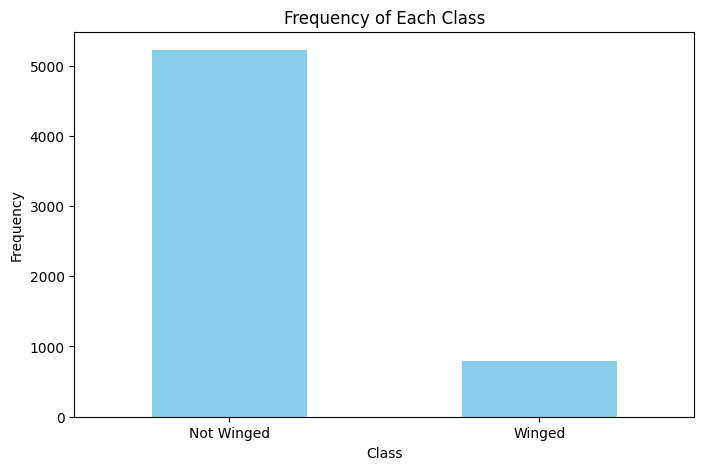

In [12]:
# Plotting frequencies of classes to check for data imbalance
source_counts = df['Source'].value_counts()
plt.figure(figsize=(8, 5))
source_counts.plot(kind='bar', color='skyblue')
plt.title("Frequency of Each Class")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=0)  
plt.show()

### Observation: Not Winged class has way more examples than Winged, We'd either have to sample equal number of images from both sets or use a weight balanced optimizer

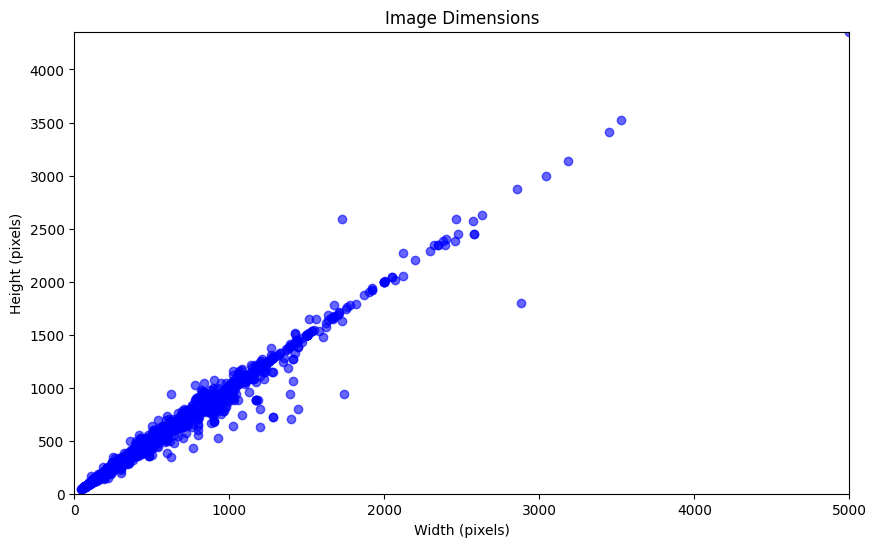

In [13]:
# Plotting the image pixel values
widths = []
heights = []

for file_path in df['File_Path']:
    if os.path.exists(file_path):  
        with Image.open(file_path) as img:
            widths.append(img.width)
            heights.append(img.height)

plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, color='blue', alpha=0.6)
plt.title("Image Dimensions")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.xlim(0, max(widths))  
plt.ylim(0, max(heights))  
plt.show()

### Observation: The dimensions of images are varying, we'd have to resize all of them to a common size

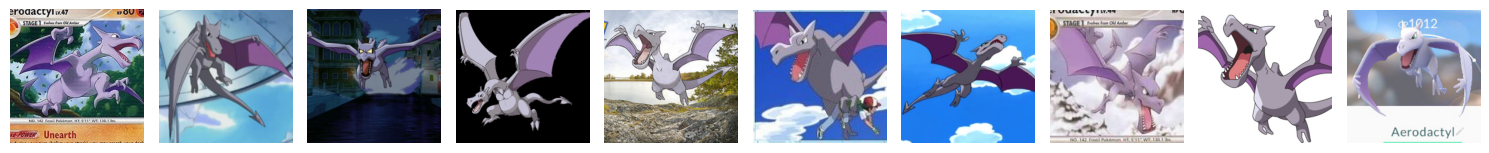

In [14]:
# Plotting 10 images after they've been resized
new_size = (224, 224)
resized_images = []

for image_path in df['File_Path'][:10]:  
    with Image.open(image_path) as img: 
        resized_img = img.resize(new_size)
        resized_images.append(resized_img)

plt.figure(figsize=(15, 10))
for i, resized_img in enumerate(resized_images):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(resized_img)
    plt.axis('off')  
plt.tight_layout()
plt.show()

### Observation: After resizing, the image retains its prominent features, so we can expect a good fit. 

Interestingly (using Aerodactyl as a case study), the pokemons are captured with different backgrounds. This could be:
- pokemon card
- from the cartoon/anime
- from a drawing
- a 3D rendering
- Pokemon Go
- realistic background
- empty/single color background

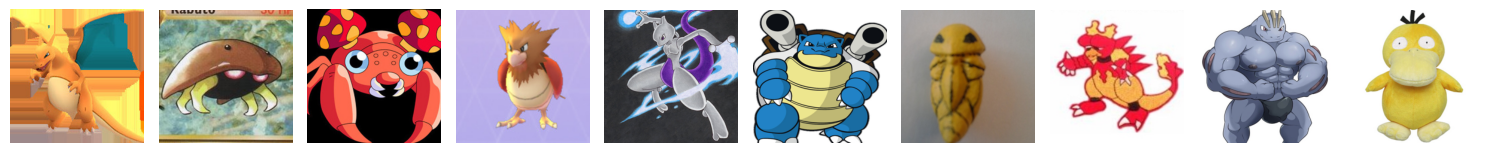

In [34]:
#Check if the style of images is consistent across the Pokemon characters
np.random.seed(99)
random_file_paths = np.random.choice(df['File_Path'], size=10, replace=False)  # Random selection
pokemon =[]

# Loop through the randomly selected file paths
for image_path in random_file_paths:
    with Image.open(image_path) as img:
        resized_img = img.resize(new_size)
        pokemon.append(resized_img)

# Plot the resized images
plt.figure(figsize=(15, 10))
for i, resized_img in enumerate(pokemon):
    plt.subplot(1, 10, i + 1)  # Display images in a 1x10 grid
    plt.imshow(resized_img)
    plt.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()

After ploting multiple random images of the Pokemon characters, we learned that the images of characters various in the style of visual representation.
- Screenshots of Pokemon Go
- Screenshots from the cartoon/anime
- Crop out of Pokemon card
- Fan drawings
- 3D rendering
- Plush photos


There are also variations in the depictions of the pokemon:
- orientation
- shape
- for some pokemon, there may be special forms that make it hard to distinguish
- there is possibility for occlusion
- inclusion of English text

However, generally, the pokemon is centered in the image and is the main object.

# Data Preprocessing

In [35]:
# Arrays to store flattened images and their classifications
X = []
y = []

In [36]:
# Going through all images and resizing them, converting them to grayscale and normalizing pixel values
for index, row in df.iterrows():
    image_path = row['File_Path']
    img = Image.open(image_path)

    # Resize images to 224 x 224
    img = img.resize((224, 224))  

    # Convert images to grayscale
    img = img.convert('L') 
    
    # Normalize pixel values
    img = np.array(img) / 255.0  
    
    X.append(img)
    y.append(1 if row['Source'] == 'Winged' else 0)
X = np.array(X)
y = np.array(y)

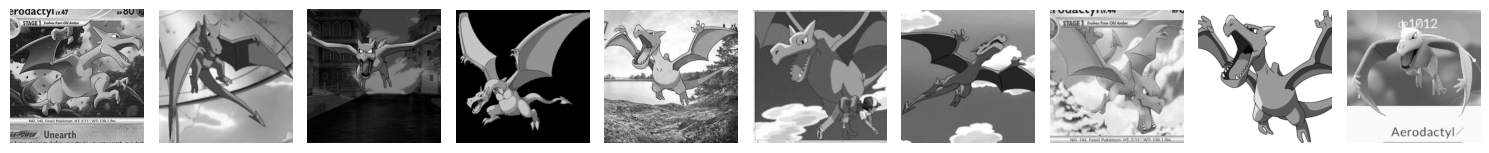

In [37]:
# Plotting the first 10 images after preprocessing
plt.figure(figsize=(15, 10))
for i, img in enumerate(X[:10]):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img, cmap='gray') 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [38]:
# Balancing the data set by random sampling
id_not_winged = np.where(y == 0)[0]
id_winged = np.where(y == 1)[0]
sample_not_winged = np.random.choice(id_not_winged, size=600, replace=False)
sample_winged = np.random.choice(id_winged, size=600, replace=False)
sample = np.concatenate((sample_not_winged, sample_winged), axis=0)
X = X[sample]
y = y[sample]
# Creating Train/Validate/Test splits (80/10/10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
X_train.shape, X_val.shape, X_test.shape

((960, 224, 224), (120, 224, 224), (120, 224, 224))